In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import os

In [3]:
def parseParameters(name):
    var_dict = {}

    param_tuple = name.split("__")

    for tuple in param_tuple:
        name, value = tuple.split("--")

        var_dict[name] = float(value)

    return var_dict


def generateCommand(struct_name, save="False", plot="False"):
    params_str = struct_name.split("__")

    for i in range(len(params_str)):
        params_str[i] = params_str[i].replace("--", " ")
        params_str[i] = "--" + params_str[i]

    return " ".join(params_str) + " -s " + save + " -pt " + plot

In [4]:
t_lower = 0.0
t_upper = 5.0

k = 1.0

size_t = int(((t_upper - t_lower) / (k)))

lmb_var = 0.1

lmb_list = np.linspace(
    1.8 * (1 - lmb_var), 1.8 * (1 + lmb_var), num=size_t + 1, endpoint=True
)

print(
    "Steps in time = {:d}\n".format(
        size_t,
    )
)

t_np = np.linspace(t_lower, t_upper, num=size_t + 1, endpoint=True)

for i, lbm_nb in enumerate(lmb_list):

    struct_name = (
        "k--"
        + str(k)
        + "__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--"
        + str(lbm_nb)
        + "__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--"
        + str(t_lower)
        + "__t_upper--"
        + str(t_upper)
    )

    os.system(
        "python3 edo_fdm_model.py "
        + generateCommand(struct_name, save="True", plot="True")
    )

    if i == 0:
        args_dict = parseParameters(struct_name)

        phi = args_dict["phi"]
        ksi = args_dict["ksi"]
        cb = args_dict["cb"]
        C_nmax = args_dict["Cn_max"]
        mi_n = args_dict["mi_n"]
        lambd_bn = args_dict["lambd_bn"]
        y_n = args_dict["y_n"]

        with open("edo_fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
            Cp_old = pk.load(f)

        with open("edo_fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
            Cl_old = pk.load(f)

    else:
        with open("edo_fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
            Cp_new = pk.load(f)

        with open("edo_fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
            Cl_new = pk.load(f)

        Cp_old = np.vstack((Cp_old.copy(), Cp_new))
        Cl_old = np.vstack((Cl_old.copy(), Cl_new))

    print(i + 1, "de", len(lmb_list))

Steps in time = 5



1 de 6
2 de 6
3 de 6
4 de 6
5 de 6
6 de 6


In [5]:
tt, ll = np.meshgrid(t_np, lmb_list)

data_input_np = np.array([Cp_old.flatten(), Cp_old.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = (
        torch.tensor(tt, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    lambd_nb = (
        torch.tensor(ll, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32).to(device)

else:
    device = torch.device("cpu")
    t = torch.tensor(tt, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    lambd_nb = torch.tensor(ll, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    data_input = torch.tensor(data_input_np, dtype=torch.float32)

print(device)

cpu


In [6]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [7]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [8]:
def generate_model(arch_str):

    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:

        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(activation_dict[activation](2, int(out_neurons)))

                else:
                    modules.append(nn.Linear(2, int(out_neurons)))
                    modules.append(activation_dict[activation]())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](int(in_neurons), int(out_neurons))
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                    modules.append(activation_dict[activation]())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [9]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate=none)
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [10]:
def initial_condition(t):
    Cl = torch.zeros_like(t)
    Cp = torch.zeros_like(t) + 0.2
    return torch.cat([Cl, Cp], dim=1)

In [11]:
def pde(t,lambd_nb, model):

    mesh = torch.cat([t, lambd_nb], dim=1)

    Cl, Cp = model(mesh).split(1, dim=1)

    # Calculando Cp

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cp_eq = (cb - lambd_nb * Cl) * Cp * phi - dCp_dt

    # Calculando Cl

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cl_eq = (y_n * Cp * (C_nmax - 1) - (lambd_bn * Cp + mi_n)) * Cl * phi - dCl_dt

    del dCl_dt
    del dCp_dt

    torch.cuda.empty_cache()

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [12]:
loss_fn = nn.MSELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
decay_rate = 0.99

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

n_epochs = 500
batch_size = 10000
C_pde_loss_it = torch.zeros(n_epochs).to(device)
C_data_loss_it = torch.zeros(n_epochs).to(device)
C_initial_loss_it = torch.zeros(n_epochs).to(device)
C_initial = initial_condition(t).to(device)

for epoch in range(n_epochs):
    for i in range(0, len(t), batch_size):

        t_initial = torch.zeros_like(t[i : i + batch_size])

        mesh = torch.cat([t_initial, lambd_nb[i : i + batch_size]], dim=1)
        C_initial_pred = model(mesh)

        loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

        mesh = torch.cat([t[i : i + batch_size], lambd_nb[i : i + batch_size]], dim=1)
        C_pred = model(mesh)

        loss_pde = loss_fn(
            pde(t[i : i + batch_size], lambd_nb[i : i + batch_size], model),
            torch.cat([t_initial, t_initial], dim=1),
        )

        loss_data = loss_fn(C_pred, data_input[i : i + batch_size])

        loss = 10*loss_initial + 10*loss_pde + loss_data
        # loss = loss_initial + loss_data

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    C_pde_loss_it[epoch] = loss_pde.item()
    C_initial_loss_it[epoch] = loss_initial.item()
    C_data_loss_it[epoch] = loss_data.item()

    if epoch % 100 == 0:
        print(f"Finished epoch {epoch}, latest loss {loss}")

Finished epoch 0, latest loss 0.2878451645374298


Finished epoch 100, latest loss 0.07217639684677124
Finished epoch 200, latest loss 0.06926610320806503
Finished epoch 300, latest loss 0.016061779111623764
Finished epoch 400, latest loss 0.015748415142297745


In [13]:
pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

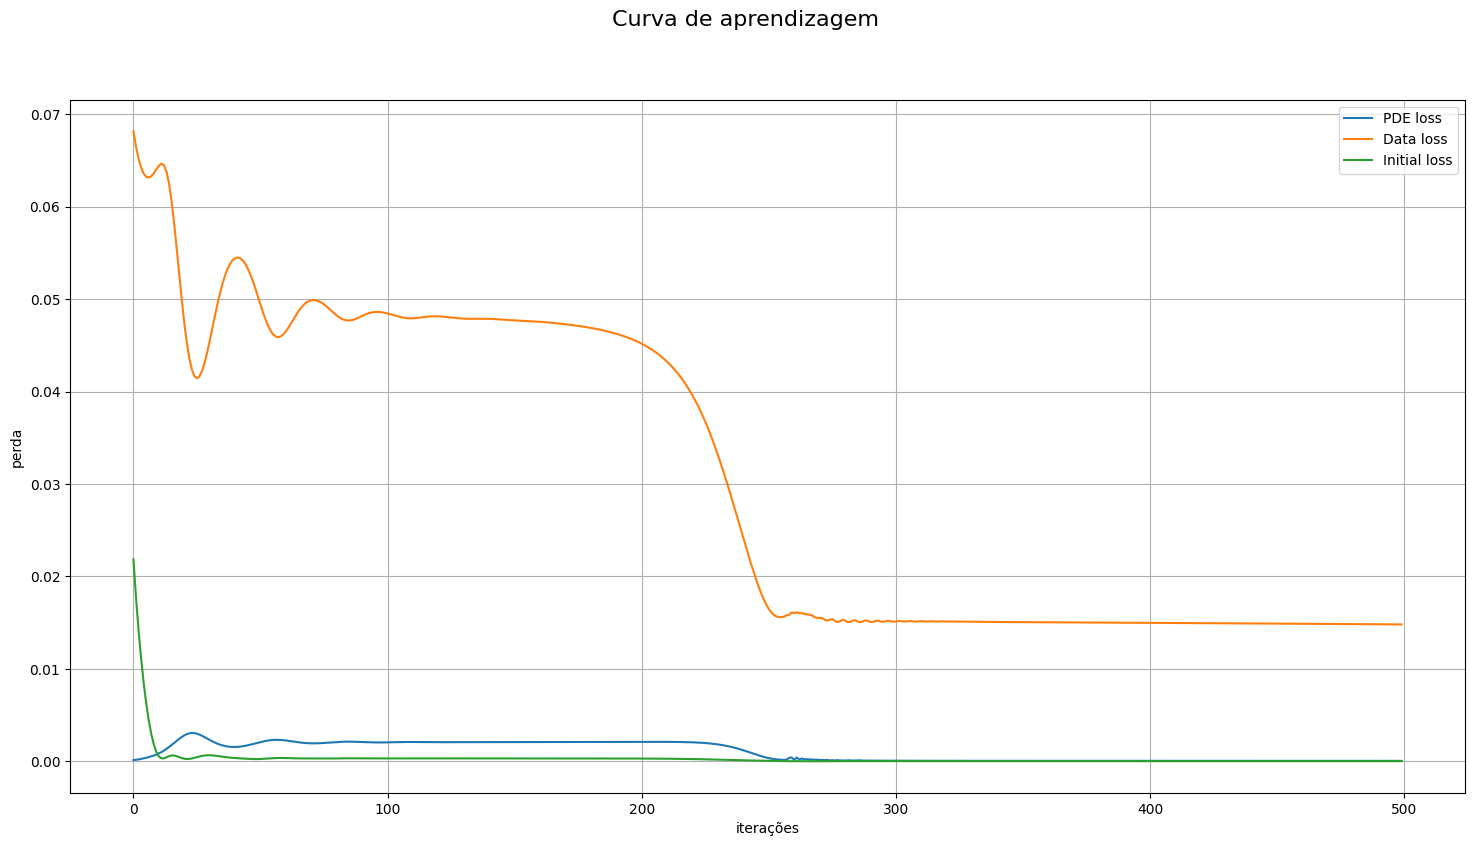

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.savefig("learning_curves/" + pinn_file + ".png")

In [17]:
model_cpu = model.to("cpu")

speed_up = []

mesh = torch.cat([t, lambd_nb], dim=1)

for i in range(10):
    
    fdm_start = time.time()

    for lbm_nb in lmb_list:

        struct_name = (
            "k--"
            + str(k)
            + "__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--"
            + str(lbm_nb)
            + "__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--"
            + str(t_lower)
            + "__t_upper--"
            + str(t_upper)
        )

        os.system("python3 edo_fdm_model.py " + generateCommand(struct_name, save="False", plot="False"))

    fdm_end = time.time()

    pinn_start = time.time()

    with torch.no_grad():
        Cl_pinn, Cp_pinn = model_cpu(mesh).split(1, dim=1)

    pinn_end = time.time()

    fdm_time = fdm_end - fdm_start

    pinn_time = pinn_end - pinn_start

    speed_up.append(fdm_time / pinn_time)

In [26]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten())
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten())
    ]
)

In [ ]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [27]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

Erro absoluto médio 0.32024586
Erro absoluto máximo 0.39611527
Speed Up: 5267.497854702982 +/-6761.833328314116


In [31]:
with open("edo_pinn_sim/" + pinn_file + ".pkl", "wb") as f:
    pk.dump(output, f)

FileNotFoundError: [Errno 2] No such file or directory: 'edo_pinn_sim/epochs_500__batch_10000__arch_Tanh--32__Tanh--32__Tanh--32__GELU--32.pkl'

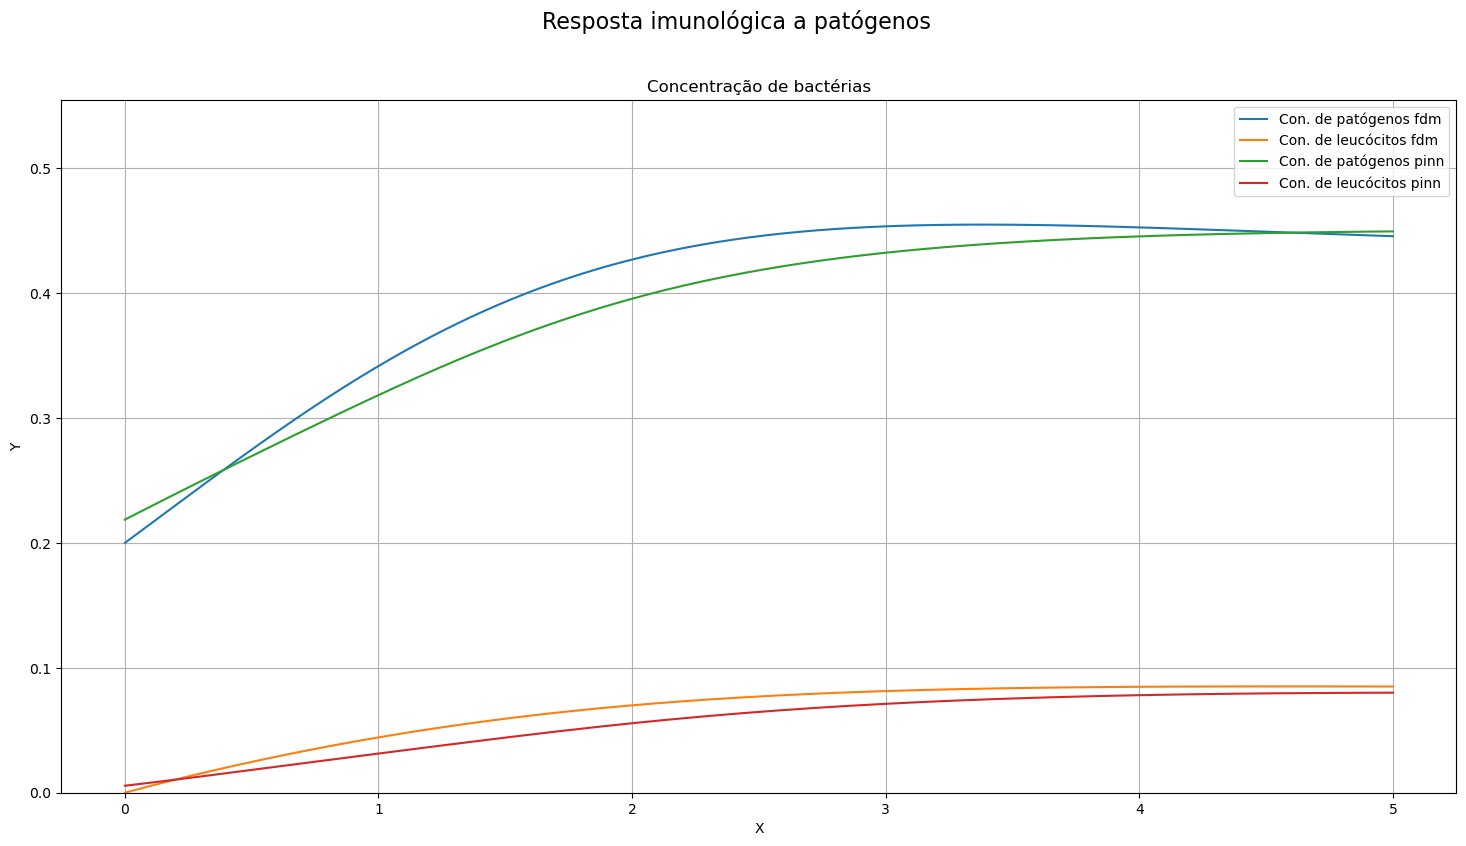

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


vmin = 0
vmax = np.max([np.max(Cl), np.max(Cp)])

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.plot(t_cpu.detach().numpy(), Cp, label="Con. de patógenos fdm")
ax.plot(t_cpu.detach().numpy(), Cl, label="Con. de leucócitos fdm")
ax.plot(t_cpu.detach().numpy(), Cp_pinn, label="Con. de patógenos pinn")
ax.plot(t_cpu.detach().numpy(), Cl_pinn, label="Con. de leucócitos pinn")
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()

In [ ]:
import glob

file_list = glob.glob("edo_pinn_sim/*")
file_list

['edo_pinn_sim/epochs_10000__batch_1000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_10000__batch_5000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_20000__batch_10000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_1000__batch_10000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_10000__batch_10000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_1000__batch_1000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_1000__batch_5000__arch_Elu--4__.pkl',
 'edo_pinn_sim/epochs_500__batch_10000__arch_Tanh--16__Tanh--16__Tanh--16__Linear--16.pkl']